In [1]:
import pywavefront
import os
import random
import cv2
import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
category = {
    "Airplane": "02691156",
    "Bag": "02773838",
    "Cap": "02954340",
    "Car": "02958343",
    "Chair": "03001627",
    "Earphone": "03261776",
    "Guitar": "03467517",
    "Knife": "03624134",
    "Lamp": "03636649",
    "Laptop": "03642806",
    "Motorbike": "03790512",
    "Mug": "03797390",
    "Pistol": "03948459",
    "Rocket": "04099429",
    "Skateboard": "04225987",
    "Table": "04379243"
}

In [3]:
#Gets the model given it's category and path. If model ID not specified, gets a random one.
def getModelPath(cat, model_id=None):
    if model_id == None:
        model_id = getRandomModelCategory(cat)
    #Accept both category and ID.
    try:
        cat_id = category[cat]
    except:
        cat_id = cat
    return(os.path.join(os.getcwd(), "ShapeNetCore/ShapeNetCore.v2", cat_id , model_id))

In [4]:
#Gets a random model ID in this category
def getRandomModelCategory(cat):
    cat_id = category[cat]
    dirs = [x for x in os.listdir(os.path.join(os.getcwd(), "ShapeNetCore/ShapeNetCore.v2", cat_id))]
    return(random.choice(dirs))

In [5]:
getModelPath("Chair")

'/home/mmvc/mmvc-ny-local/mmvc-ny-local-002/Bokang_Jia/ShapeNet/ShapeNetCore/ShapeNetCore.v2/03001627/d645bf9037e7dabda341228b21d337a9'

In [6]:
obj_path = os.path.join(getModelPath("Chair", "b021f7d705c4113ac7bed72580dc30f"), "models/model_normalized.obj")
obj = pywavefront.Wavefront(obj_path)

In [7]:
print(obj)

In [8]:
# for name, material in obj.materials.items():
#     print("Format of vertex: ", material.vertex_format)
#     print("Number of verticies: ", len(material.vertices))
#     print("Preview first 10 verticies: ", material.vertices[0:10])
#     print("Material diffuseness: ", material.diffuse)
#     print("Material ambientness: ", material.ambient)
#     print("Material texture: ",material.texture)
#     print()

# Load model images and camera K/RT data

In [9]:
#Some parameters
#modelcatnum = "04460130"
#modelIDnum = "9024bb81d726d584dfda46c9a34dab22"
modelcatnum = "03001627"
modelIDnum = "ff969b22a8de5eac30e06a011e63236a"

In [10]:
#Gets the 02th image at imgPath.
def showModelImage(path, index):
    imgpath = os.path.join(path, "rendering/" + str(index) + ".png")
    im = cv2.imread(imgpath)
    plt.imshow(im)
    plt.show()

In [11]:
#Gets the 02th metadata array at imgPath. 
#Metadata is as follows "azimuth, elevation, in-plane rotation, distance, the field of view."
def getModelMeta(path, index):
    metaPath = os.path.join(path, "rendering/rendering_metadata.txt")
    f = open(metaPath)
    lines = f.readlines()[int(index)].strip()
    meta = [float(x) for x in lines.split(' ')]
    return(meta)

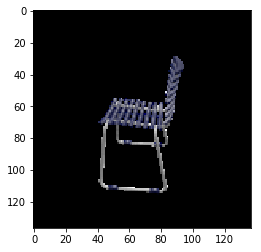

In [12]:
#Show this image
model_path = getModelPath(modelcatnum, modelIDnum)
showModelImage(model_path, "02")

In [13]:
#Obtain the metadata. "azimuth, elevation, in-plane rotation, distance, the field of view."
meta = getModelMeta(model_path, "02")

In [14]:
#Fucntion refereced from https://github.com/autonomousvision/occupancy_networks
F_MM = 35.  # Focal length
SENSOR_SIZE_MM = 32.

PIXEL_ASPECT_RATIO = 1.  # pixel_aspect_x / pixel_aspect_y
RESOLUTION_PCT = 100
SKEW = 0.
CAM_MAX_DIST = 1.75

IMG_W = 127 + 10  # Rendering image size. Network input size + cropping margin.
IMG_H = 127 + 10

CAM_ROT = np.matrix(((1.910685676922942e-15, 4.371138828673793e-08, 1.0),
                     (1.0, -4.371138828673793e-08, -0.0),
                     (4.371138828673793e-08, 1.0, -4.371138828673793e-08)))

blender_T = np.array([
    [1, 0., 0],
    [0, 0, -1],
    [0, 1, 0.],
])

def getBlenderProj(az, el, distance_ratio, img_w=IMG_W, img_h=IMG_H):
    """Calculate 4x3 3D to 2D projection matrix given viewpoint parameters."""

    # Calculate intrinsic matrix.
    # notice that the scale evaluates to 1
    scale = RESOLUTION_PCT / 100
    f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
    f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
    u_0 = img_w * scale / 2
    v_0 = img_h * scale / 2
    K = np.matrix(((f_u, SKEW, u_0), (0, f_v, v_0), (0, 0, 1)))

    # Calculate rotation and translation matrices.
    # Step 1: World coordinate to object coordinate.
    sa = np.sin(np.radians(-az))
    ca = np.cos(np.radians(-az))
    se = np.sin(np.radians(-el))
    ce = np.cos(np.radians(-el))
    R_world2obj = np.transpose(np.matrix(((ca * ce, -sa, ca * se),
                                          (sa * ce, ca, sa * se),
                                          (-se, 0, ce))))

    # Step 2: Object coordinate to camera coordinate.
    R_obj2cam = np.transpose(np.matrix(CAM_ROT))
    R_world2cam = R_obj2cam * R_world2obj
    cam_location = np.transpose(np.matrix((distance_ratio * CAM_MAX_DIST,
                                           0,
                                           0)))
    T_world2cam = -1 * R_obj2cam * cam_location

    # Step 3: Fix blender camera's y and z axis direction.
    R_camfix = np.matrix(((1, 0, 0), (0, -1, 0), (0, 0, -1)))
    R_world2cam = R_camfix * R_world2cam
    T_world2cam = R_camfix * T_world2cam

    RT = np.hstack((R_world2cam, T_world2cam))

    return K, RT

In [15]:
print(meta[0], meta[1], meta[3])

263.928266144 26.1970665065 0.858990236647


In [16]:
K, RT = getBlenderProj(meta[0], meta[1], meta[3])

In [17]:
np.dot(K,RT)

matrix([[ -1.42501927e+02,  -7.69684545e+01,  -3.02399955e+01,
           1.02971455e+02],
        [ -4.95688177e-01,   4.65996561e+00,  -1.64691950e+02,
           1.02971464e+02],
        [  9.49085640e-02,  -8.92247468e-01,  -4.41459874e-01,
           1.50323291e+00]])

In [18]:
#Postprocess the K and RT matricies.
RT = np.asarray(RT)
K = np.asarray(K)
M = RT[:, :3] @ blender_T
c = RT[:, 3:]
out_dict = {}
out_dict['camera_mat_%d' % 0] = K
out_dict['world_mat_%d' % 0] = np.concatenate([M, c], axis=1)

In [19]:
out_dict['world_mat_0']

array([[ -9.94390245e-01,   3.92213979e-08,   1.05773534e-01,
         -2.87220560e-15],
       [ -4.66948058e-02,  -8.97280993e-01,  -4.38983389e-01,
          6.57083976e-08],
       [  9.49085640e-02,  -4.41459874e-01,   8.92247468e-01,
          1.50323291e+00]])

In [20]:
out_dict['camera_mat_0']

array([[ 149.84375,    0.     ,   68.5    ],
       [   0.     ,  149.84375,   68.5    ],
       [   0.     ,    0.     ,    1.     ]])

In [21]:
# out_dict['world_mat_0'] = np.zeros((3,4))
# out_dict['world_mat_0'][0,0] = 1
# out_dict['world_mat_0'][1,1] = 1
# out_dict['world_mat_0'][2,2] = 1

In [22]:
# out_dict['world_mat_0']

# Load the pointcloud

In [23]:
def loadPcd(model_path):
    obj_path = os.path.join(model_path, "models/model_normalized.pcd")
    data = []
    f = open(obj_path, 'r')
    for line in f:
        splitline = line.strip().split(' ')
        try:
            data.append([float(x) for x in splitline])
        except:
            pass
    data = np.asarray(data)
    data.astype(float)
    return(data)

In [24]:
def loadObjVec(model_path):
    #As a placeholder, just use the verticies information for now.
    obj_path = os.path.join(model_path, "models/model_normalized.obj")
    data = []
    f = open(obj_path, 'r')
    for line in f:
        if (line[0] == 'v' and line[1]==' '):
            splitline = line[2:].strip().split(' ')
            data.append([float(x) for x in splitline])
    data = np.asarray(data)
    data.astype(float)
    return(data)

In [25]:
data = loadPcd(model_path)

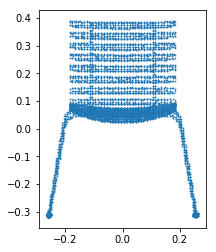

In [26]:
#Simple projection of points to 2d.
fig = plt.figure()
fig.set_size_inches(3,4)
ax = fig.add_subplot(111)
ax.scatter(data[:,0], data[:,1], s=0.5)
plt.show()

In [27]:
#Interactive 3d plot.
import ipyvolume as ipv
ipv.figure()
ipv.scatter(data[:,0], data[:,1], data[:,2], size=0.5, marker="sphere")
print(ipv.view(1,0,2.0))
ipv.show()

(1, 0, 2.0)


In [28]:
for i in range(-100,-200):
    ipv.view(-185)
print(ipv.view(-185))

(-185, 0.0, 2.0)


# Project the pointcloud based on above orientation

In [58]:
#Camera and world matrix projections from http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
# P = np.dot(out_dict['camera_mat_0'],out_dict['world_mat_0'] )
points = np.transpose(data)
points = np.vstack((points,np.ones((1,points.shape[1])))) #Add extra one padding for 3x4 matrix.
# newpoints = np.dot(out_dict['camera_mat_0'],np.dot(out_dict['world_mat_0'],points))
newpoints = np.dot(K,np.dot(RT,points))

In [59]:
points.shape

(4, 7290)

In [60]:
#newproj = np.matrix([[149,0,0,0],[0,149,0,0],[0,0,1,0]])
# newpoints = np.dot(newproj,points)

In [61]:
# Projecting 3d transformed point to 2d. 
# https://stackoverflow.com/questions/39447624/back-projecting-3d-world-point-to-new-view-image-plane
converted = newpoints[:2]/newpoints[-1]

In [62]:
# np.clip(converted, 0, 137, out=converted)

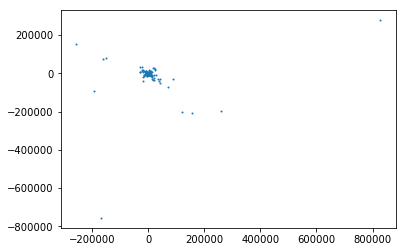

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(converted[0,:], converted[1,:], s=1)
plt.show()

In [56]:
#Interactive 3d plot.
import ipyvolume as ipv
ipv.figure()
ipv.scatter(newpoints[0,:], newpoints[1,:], newpoints[2,:], size=0.5, marker="sphere")
ipv.show()

In [35]:
# #Reference code from Lingjing for projecting to 2d. Constant camera plane?

def project_3d_on_2d(obj="ape",id=0,points=None):
    root = "../linemod/"+obj	
    #0.read transformation matrix
    Transformation = []
    with open(root+"/transform.dat") as f:
        line = f.readline()
        for _ in range(12):
            line = f.readline().split(" ")
            Transformation.append(float(line[-1]))
    Transformation = np.array(Transformation,dtype=np.float64).reshape(3,4)

    #1.read points
    if points is None:
        #read the points in OLDmesh.py
        plydata = PlyData.read(root+"/OLDmesh.ply")
        #1.2save the point cloud data into a n*3 matrix
        nx = np.expand_dims(plydata['vertex']['x'],0) 
        ny = np.expand_dims(plydata['vertex']['y'],0) 
        nz = np.expand_dims(plydata['vertex']['z'],0)
        points = np.vstack((nx,ny,nz)) / 10.0
    points = np.dot(Transformation[:,:-1],points)
    points = points + Transformation[:,-1:]*100

    #2.read R,T matrix
    rfile = root+"/data/rot{0}.rot".format(id)
    tfile = root+"/data/tra{0}.tra".format(id)
    Rotation = np.zeros((4,3))
    Translation = np.ones((4,1))
    with open(rfile) as f:
        line = f.readline()
        for i in range(3):
            line = f.readline()
            Rotation[i] = np.array(map(float,line.split(" ")[:-1]),dtype=np.float64)
    with open(tfile) as f:
        line = f.readline()
        for i in range(3):
            line = f.readline()
            Translation[i] = np.array(map(float,line.split(" ")[:-1]),dtype=np.float64)

    #3.matrix multiplication
    RT = np.hstack((Rotation,Translation))
    points = np.vstack((points,np.ones((1,points.shape[1]))))
    # points = np.dot(Transformation,points)
    Plane = np.array([[572.4114, 0., 325.2611,0.],
                      [0., 573.57043, 242.04899,0.],
                      [0., 0., 1.,0.]])
    newpoints = np.dot(Plane,np.dot(RT,points))

    return newpoints[:2]/newpoints[-1]